# Declaring Addresses & Adding Files

## Declaring Addresses

In [1]:
import os, shutil

drive_base = "/content/drive/MyDrive/captioneer"
drive_scripts = os.path.join(drive_base, "scripts")
drive_captions = os.path.join(drive_base, "processed_captions")
drive_images_tar = os.path.join(drive_base, "processed_images.tar.gz")  # update if name differs

colab_scripts = "/content/scripts"
colab_captions = "/content/processed_captions"
colab_images = "/content/processed_images"

os.makedirs(colab_scripts, exist_ok=True)

## Copying Scripts

In [2]:
for fname in ["dataset_lstm.py", "model_lstm.py", "train_lstm.py"]:
    src = os.path.join(drive_scripts, fname)
    dst = os.path.join(colab_scripts, fname)
    if os.path.exists(dst):
        os.remove(dst)
    if os.path.exists(src):
        shutil.copy(src, dst)
        print("Copied", fname, "to", dst)
    else:
        print("not found in drive:", src)
print("Scripts are in", colab_scripts)

Copied dataset_lstm.py to /content/scripts/dataset_lstm.py
Copied model_lstm.py to /content/scripts/model_lstm.py
Copied train_lstm.py to /content/scripts/train_lstm.py
Scripts are in /content/scripts


## Copy & Extracting `processed_images.tar.gz`

In [3]:
import tarfile

# remove existing folder if present
if os.path.exists(colab_images):
    shutil.rmtree(colab_images)

# copy tar.gz from Drive to /content
tmp_tar = "/content/processed_images.tar.gz"
if os.path.exists(tmp_tar):
    os.remove(tmp_tar)
shutil.copy(drive_images_tar, tmp_tar)
print("Copied tarball to", tmp_tar)

# extract
with tarfile.open(tmp_tar, "r:gz") as tar:
    tar.extractall(path=colab_images)
print("Extraction complete. Images directory:", colab_images)


Copied tarball to /content/processed_images.tar.gz


/tmp/ipython-input-2990224163.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=colab_images)


Extraction complete. Images directory: /content/processed_images


## Copying `processed_captions`

In [4]:
import glob

# copy captions folder
if os.path.exists(colab_captions):
    print("Removing existing", colab_captions)
    shutil.rmtree(colab_captions)
shutil.copytree(drive_captions, colab_captions)
print("Copied processed captions to", colab_captions)

# quick checks
npy_files = glob.glob(os.path.join(colab_images, "*.npy"))
print("Number of feature .npy files:", len(npy_files))
json_files = glob.glob(os.path.join(colab_captions, "*.json"))
print("Processed captions files:", json_files)

Copied processed captions to /content/processed_captions
Number of feature .npy files: 31783
Processed captions files: ['/content/processed_captions/vocab_idx2word.json', '/content/processed_captions/meta.json', '/content/processed_captions/cleaned_captions.json', '/content/processed_captions/sequences_val.json', '/content/processed_captions/sequences_train.json', '/content/processed_captions/vocab_word2idx.json', '/content/processed_captions/sequences_test.json']


## Checking Features

In [5]:
import numpy as np

npy_files = sorted(glob.glob(os.path.join(colab_images, "*.npy")))
if len(npy_files) == 0:
    raise RuntimeError("No .npy files found in " + colab_images)
sample = np.load(npy_files[0])
print("Sample file:", npy_files[0])
print("Feature shape:", sample.shape, "dtype:", sample.dtype)

Sample file: /content/processed_images/1000092795.npy
Feature shape: (2048,) dtype: float32


# Training

## Dataloader Creation

In [7]:
import sys
sys.path.append('/content/scripts')
from importlib import reload
import dataset_lstm
reload(dataset_lstm)

from torch.utils.data import DataLoader
train_seq = os.path.join(colab_captions, "sequences_train.json")
features_dir = colab_images

ds = dataset_lstm.CaptionFeatureDataset(train_seq, features_dir, vocab_json="/content/processed_captions/vocab_word2idx.json")
loader = DataLoader(ds, batch_size=8, shuffle=True, collate_fn=dataset_lstm.collate_fn)
batch = next(iter(loader))
feats, seqs, names = batch
print("Batch feature shape:", feats.shape)
print("Batch seqs shape:", seqs.shape)
print("Sample image names:", names[:4])

Batch feature shape: torch.Size([8, 2048])
Batch seqs shape: torch.Size([8, 30])
Sample image names: ['2765815424.jpg', '4834744984.jpg', '4891825066.jpg', '8001609110.jpg']


## Importing and Preparation
double checking libraries and paths and scripts

In [ ]:
import os, sys, json, glob, numpy as np
from importlib import reload
import torch
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt

# add scripts path
sys.path.append('/content/scripts')

import dataset_lstm, model_lstm, train_lstm
reload(dataset_lstm); reload(model_lstm); reload(train_lstm)

# paths (adjust if needed)
colab_captions = "/content/processed_captions"
colab_images = "/content/processed_images"
vocab_path = os.path.join(colab_captions, "vocab_word2idx.json")
idx2word_path = os.path.join(colab_captions, "vocab_idx2word.json")
train_seq = os.path.join(colab_captions, "sequences_train.json")
val_seq = os.path.join(colab_captions, "sequences_val.json")
test_seq = os.path.join(colab_captions, "sequences_test.json")
models_dir = "/content/models"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# load vocab (word2idx) and idx2word conversion
with open(vocab_path, "r", encoding="utf-8") as f:
    word2idx = json.load(f)
with open(idx2word_path, "r", encoding="utf-8") as f:
    raw_idx2 = json.load(f)
# convert keys back to ints
idx2word = {int(k): v for k, v in raw_idx2.items()}

start_token = word2idx.get("<START>", 2)
end_token = word2idx.get("<END>", 3)
pad_token = word2idx.get("<PAD>", 0)
print("Vocab size:", len(word2idx))

## Sanity Check
running a single batch

In [10]:
batch_size = 8
ds = dataset_lstm.CaptionFeatureDataset(train_seq, colab_images, vocab_path)
loader = DataLoader(ds, batch_size=batch_size, shuffle=True, collate_fn=dataset_lstm.collate_fn, num_workers=2)

# instantiate small models
feat_dim = 2048
feat_embed_dim = 1024
embed_dim = 512
hidden_dim = 1024

enc = model_lstm.EncoderIdentity(feat_dim=feat_dim, embed_dim=feat_embed_dim).to(device)
dec = model_lstm.DecoderRNN(embed_dim=embed_dim, hidden_dim=hidden_dim,
                       vocab_size=len(word2idx), num_layers=1,
                       dropout=0.5, feat_embed_dim=feat_embed_dim).to(device)

# single batch
feats, seqs, names = next(iter(loader))
feats = feats.to(device)
seqs = seqs.to(device)

optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=1e-3)
criterion = torch.nn.CrossEntropyLoss(ignore_index=pad_token)

enc.train(); dec.train()
optimizer.zero_grad()
logits = dec(enc(feats), seqs)
B, Lm1, V = logits.shape
loss = criterion(logits.view(B*Lm1, V), seqs[:,1:].reshape(-1))
loss.backward()
optimizer.step()
print("One-step train loss:", loss.item())

One-step train loss: 8.517827987670898


## Train

In [ ]:
config = {
    'train_sequences': train_seq,
    'val_sequences': val_seq,
    'features_dir': colab_images,
    'vocab_path': vocab_path,
    'save_dir': models_dir,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'batch_size': 128,
    'epochs': 50,
    'lr': 1e-3,
    'patience': 5,
    'embed_dim': 1024,
    'hidden_dim': 2048,
    'num_layers': 1,
    'dropout': 0.5,
    'feat_dim': 2048,
    'feat_embed_dim': 2048,
    'max_len': 30,
    'resume_path': ""
}

history = train_lstm.train_loop(config)

## Visualizing Losses & Scores

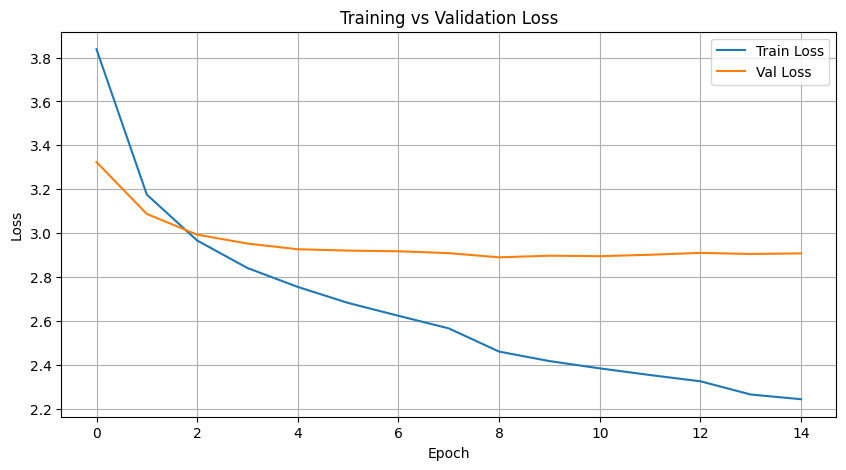

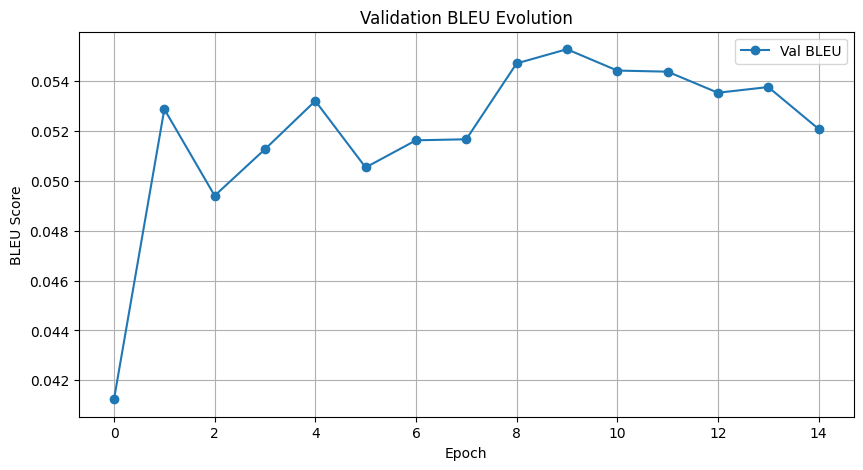

In [ ]:
import matplotlib.pyplot as plt

# Plot losses
plt.figure(figsize=(10,5))
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

# Plot BLEU scores
plt.figure(figsize=(10,5))
plt.plot(history["val_bleu"], marker="o", label="Val BLEU")
plt.xlabel("Epoch")
plt.ylabel("BLEU Score")
plt.title("Validation BLEU Evolution")
plt.legend()
plt.grid(True)
plt.show()

## Load Best Model And Check Generated Captions VS Ground Truth

### Using Kaggle to download the dataset

In [ ]:
from google.colab import files
import kagglehub

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aryajelodar","key":"d479d9cb0888eb4c8890d2eb722fe84c"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
path = kagglehub.dataset_download("eeshawn/flickr30k")

100%|██████████| 4.08G/4.08G [00:35<00:00, 123MB/s]

Extracting files...


Loading checkpoint: /content/models/best_model_epoch9_bleu0.0547.pt


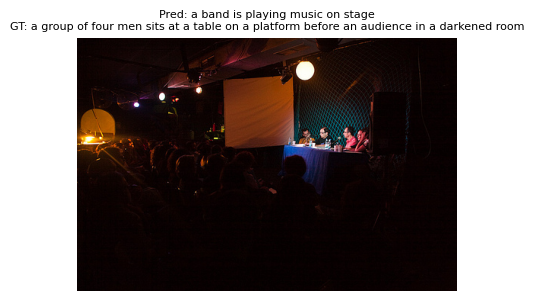

In [ ]:
import torch
from PIL import Image
import matplotlib.pyplot as plt

# find latest best model
ckpts = sorted(glob.glob(os.path.join(models_dir, "best_*.pt")) + glob.glob(os.path.join(models_dir, "best_model_*.pt")))
if not ckpts:
    # fallback take any saved model
    ckpts = sorted(glob.glob(os.path.join(models_dir, "*.pt")))
if not ckpts:
    raise RuntimeError("No checkpoints found in " + models_dir)
ckpt = ckpts[-1]
print("Loading checkpoint:", ckpt)
state = torch.load(ckpt, map_location=device)
enc = model_lstm.EncoderIdentity(feat_dim=2048, embed_dim=1024).to(device)
dec = model_lstm.DecoderRNN(embed_dim=512, hidden_dim=1024, vocab_size=len(word2idx), feat_embed_dim=1024).to(device)
enc.load_state_dict(state.get('encoder_state', state.get('encoder', state.get('encoder_state', {}))))
dec_state = state.get('decoder_state', state.get('decoder', state.get('decoder_state', {})))
dec.load_state_dict(dec_state)

enc.eval(); dec.eval()

# helper to convert token ids -> words
def ids_to_sentence(ids, idx2word_map):
    words = []
    for i in ids:
        if i==pad_token: break
        w = idx2word_map.get(i, "<UNK>")
        if w in ("<START>", "<END>", "<PAD>"):
            if w=="<END>":
                break
            else:
                continue
        words.append(w)
    return " ".join(words)

# sample some val images and show predictions + one GT caption
val_ds = dataset_lstm.CaptionFeatureDataset(val_seq, colab_images, vocab_path)
# pick 6 random image keys (unique)
import random
sample_imgs = random.sample(list(set([item[0] for item in val_ds.items])), 1)

plt.figure(figsize=(12,8))
for i, img_name in enumerate(sample_imgs):
    feat = np.load(os.path.join(colab_images, img_name.replace('.jpg','.npy')))
    feat_t = torch.tensor(feat).unsqueeze(0).float().to(device)
    with torch.no_grad():
        pred_ids = dec.greedy_decode(enc(feat_t), start_token=start_token, max_len=100)[0].cpu().tolist()
    pred_sent = ids_to_sentence(pred_ids, idx2word)
    # load original image from your raw images folder if available
    raw_img_path = os.path.join('/root/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1/flickr30k_images', img_name)
    if not os.path.exists(raw_img_path):
        raw_img_path = None
    plt.subplot(2,3,i+1)
    if raw_img_path and os.path.exists(raw_img_path):
        im = Image.open(raw_img_path).convert('RGB')
        plt.imshow(im); plt.axis('off')
    else:
        plt.text(0.5,0.5, img_name, ha='center', va='center'); plt.axis('off')
    # get one ground truth caption from sequences json (first available)
    seqs_json = json.load(open(val_seq, 'r', encoding='utf-8'))
    gt_seq = seqs_json[img_name][0]  # first caption (padded indices)
    # convert gt indices to sentence
    gt_ids = [int(x) for x in gt_seq]
    gt_sent = ids_to_sentence(gt_ids, idx2word)
    plt.title(f"Pred: {pred_sent}\nGT: {gt_sent}", fontsize=8)
plt.tight_layout()